In [10]:
from Bio import SeqIO
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo
import itertools
import pandas as pd
from sklearn.metrics import roc_auc_score
import os
from multiprocessing import Pool, cpu_count

fasta_files = [
    "Klebsiella_dpos_ref_50.fasta",
    "Klebsiella_dpos_ref_100.fasta",
    "Klebsiella_dpos_ref_150.fasta",
    "Klebsiella_dpos_ref_200.fasta",
    "Klebsiella_dpos_ref_250.fasta",
    "Klebsiella_dpos_ref_350.fasta",
    "Klebsiella_dpos_ref_400.fasta",
    "Klebsiella_dpos_ref_full.fasta"
]

blosum62 = MatrixInfo.blosum62

def pair_score(args):
    rec1, rec2 = args
    ktype1 = rec1.description.split(' ')[1]
    ktype2 = rec2.description.split(' ')[1]
    alignments = pairwise2.align.localds(rec1.seq, rec2.seq, blosum62, -10, -0.5)
    score = max([al.score for al in alignments])
    max_self = pairwise2.align.localds(rec1.seq, rec1.seq, blosum62, -10, -0.5)
    max_score = max([al.score for al in max_self])
    normalized_score = score / max_score if max_score > 0 else 0
    true_label = 1 if ktype1 == ktype2 else 0
    return (rec1.description, rec2.description, normalized_score, true_label)

all_results = []

for fasta_file in fasta_files:
    print(f"Processing: {fasta_file}")
    records = list(SeqIO.parse(fasta_file, "fasta"))
    pairs = list(itertools.combinations(records, 2))
    with Pool(cpu_count()) as pool:
        results = pool.map(pair_score, pairs)
    for res in results:
        all_results.append((os.path.basename(fasta_file), res[0], res[1], res[2], res[3]))

df = pd.DataFrame(all_results, columns=["file", "seq1", "seq2", "normalized_score", "true_label"])
df.to_csv("all_fasta_pairwise_normalized_score.tsv", sep="\t", index=False)

Processing: Klebsiella_dpos_ref_50.fasta
Processing: Klebsiella_dpos_ref_100.fasta
Processing: Klebsiella_dpos_ref_150.fasta
Processing: Klebsiella_dpos_ref_200.fasta
Processing: Klebsiella_dpos_ref_250.fasta
Processing: Klebsiella_dpos_ref_350.fasta
Processing: Klebsiella_dpos_ref_400.fasta
Processing: Klebsiella_dpos_ref_full.fasta


In [11]:
from Bio import SeqIO
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo
import itertools
import pandas as pd
from sklearn.metrics import roc_auc_score
import os
from multiprocessing import Pool, cpu_count

input_file = "all_fasta_pairwise_normalized_score.tsv"
output_file = "all_fasta_pairwise_normalized_score.tsv"

file_map = {
    "Klebsiella_dpos_ref_50.fasta": "subseq (50 a.a.)",
    "Klebsiella_dpos_ref_100.fasta": "subseq (100 a.a.)",
    "Klebsiella_dpos_ref_150.fasta": "subseq (150 a.a.)",
    "Klebsiella_dpos_ref_200.fasta": "subseq (200 a.a.)",
    "Klebsiella_dpos_ref_250.fasta": "subseq (250 a.a.)",
    "Klebsiella_dpos_ref_350.fasta": "subseq (350 a.a.)",
    "Klebsiella_dpos_ref_400.fasta": "subseq (400 a.a.)",
    "Klebsiella_dpos_ref_full.fasta": "full-length"
}

df = pd.read_csv(input_file, sep="\t")
df["file"] = df["file"].map(file_map)
df.to_csv(output_file, sep="\t", index=False)

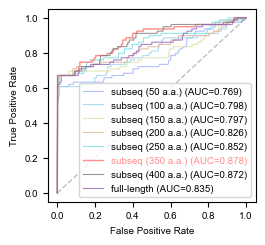

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['axes.titlesize'] = 7
mpl.rcParams['legend.title_fontsize'] = 7
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7

plot_order = [
    "subseq (50 a.a.)",
    "subseq (100 a.a.)",
    "subseq (150 a.a.)",
    "subseq (200 a.a.)",
    "subseq (250 a.a.)",
    "subseq (350 a.a.)",
    "subseq (400 a.a.)",
    "full-length"
]

color_seq = [
    "#9BB3FE",  # 50 a.a.
    "#9BD2ED",  # 100 a.a.
    "#DBE2A6",  # 150 a.a.
    "#DAB795",  # 200 a.a.
    "#74E2E2",  # 250 a.a.
    "#FE8D8D",  # 350 a.a. 
    "#7f7f7f",  # 400 a.a.
    "#9467bd"   # full-length
]
color_map = {label: color_seq[i] for i, label in enumerate(plot_order)}

df = pd.read_csv("all_fasta_pairwise_normalized_score.tsv", sep="\t")

results = []
for label in plot_order:
    group = df[df["file"] == label]
    if len(group) == 0:
        continue
    y_true = group["true_label"]
    y_score = group["normalized_score"]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_val = roc_auc_score(y_true, y_score)
    results.append({
        "label": label,
        "fpr": fpr,
        "tpr": tpr,
        "auc": auc_val
    })

highlight_label = "subseq (350 a.a.)"
highlight_color = "#FE8D8D"

plt.figure(figsize=(7*1/2.54, 6.5*1/2.54))

for res in results:
    lw = 1 if res["label"] == highlight_label else 0.8
    alpha = 1 if res["label"] == highlight_label else 0.8
    color = highlight_color if res["label"] == highlight_label else color_map.get(res["label"], "#000000")
    plt.plot(res["fpr"], res["tpr"], color=color, label=f"{res['label']} (AUC={res['auc']:.3f})", lw=lw, alpha=alpha)

plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

handles, legend_labels = plt.gca().get_legend_handles_labels()
legend = plt.legend(handles, legend_labels, loc='best')

for text in legend.get_texts():
    if highlight_label in text.get_text():
        text.set_color(highlight_color)

plt.tight_layout()
plt.savefig("../img/optimize_subseq_len.png", dpi=300)
plt.savefig("../pdf/optimize_subseq_len.pdf")